In [1]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tqdm.notebook import tqdm
import os
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPool2D, Dropout, Concatenate
from tensorflow.keras.models import Model
from numba import cuda
from tensorflow.keras.models import load_model

## Modifying the Images

In [10]:
dataset_x_path = 'custom_dataset_human_black_background/features/'
dataset_y_path = 'custom_dataset_human_black_background/labels/'
x_images = os.listdir(dataset_x_path)
y_images = os.listdir(dataset_y_path)
len(x_images), len(y_images)

(4731, 4731)

1006_x.jpg


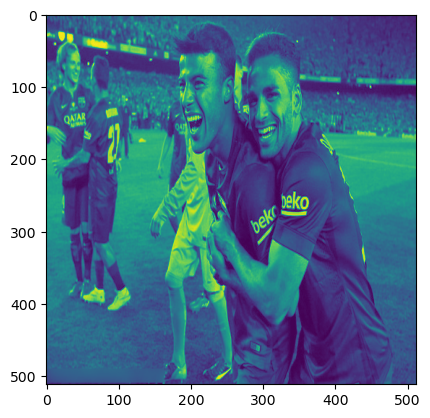

In [73]:
image_path = x_images[7]
print(image_path)
image = cv2.imread(f'{dataset_x_path}{image_path}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)

In [83]:
def apply_filter(image):
    new_image = cv2.convertScaleAbs(image, 0.1, 4)
    new_image = cv2.adaptiveThreshold(new_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return new_image

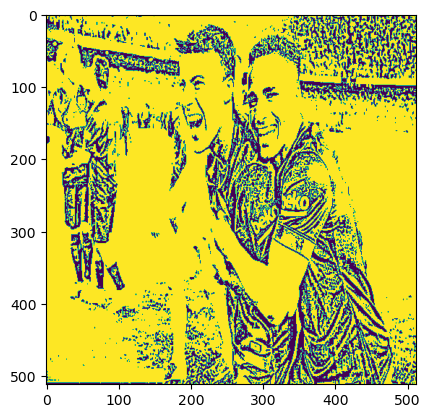

In [84]:
#Changing image contrast
image = image.astype(np.uint8)
plt.imshow(apply_filter(image))

In [85]:
#Ensuring that the directory exists
modified_image_directory = "custom_dataset_human_black_background/features_modified/"
if not os.path.exists(modified_image_directory):
    os.mkdir(modified_image_directory)

In [86]:
for i in tqdm(range(0,len(x_images))):
    image_path = x_images[i]
    image = cv2.imread(f'{dataset_x_path}{image_path}')
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    new_image = apply_filter(image.astype(np.uint8))
    cv2.imwrite(f'{modified_image_directory}{image_path}', new_image)

  0%|          | 0/4731 [00:00<?, ?it/s]

## Defining and Training Model

In [87]:
device = cuda.get_current_device()
device.reset()

In [88]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [89]:
tf.test.is_built_with_cuda()

True

In [91]:
class ImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_folder_path, y_folder_path, x, y, batch_size = 1):
        super()
        self.x = x
        self.y = y
        self.x_folder_path = x_folder_path
        self.y_folder_path = y_folder_path
        self.batch_size = batch_size
        self.on_epoch_end()


    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        start_point = index * self.batch_size
        end_point = (index + 1) * self.batch_size
        batch_images = []
        batch_labels = []
        for i in range(start_point, end_point):
            image_x = cv2.imread(f'{self.x_folder_path}{self.x[i]}')
            image_x = cv2.resize(image_x, (IMG_WIDTH, IMG_HEIGHT))
            image_x = cv2.cvtColor(image_x, cv2.COLOR_RGB2GRAY)
            image_x = image_x / 255.
            image_x = image_x.reshape(512, 512, 1)
            batch_images.append(image_x)

            image_y = cv2.imread(f'{self.y_folder_path}{self.y[i]}')
            image_y = cv2.resize(image_y, (IMG_WIDTH, IMG_HEIGHT))
            image_y = cv2.cvtColor(image_y, cv2.COLOR_RGB2GRAY)
            image_y = image_y / 255.
            image_y = image_y.reshape(512, 512, 1)
            batch_labels.append(image_y)
        
        return np.array(batch_images), np.array(batch_labels)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.x))


In [92]:
train_percentage = 0.8

In [93]:
train_image_ids = np.random.choice(len(x_images), int(len(x_images) * train_percentage), replace= False)
test_image_ids = np.delete(list(range(len(x_images))), train_image_ids)

In [94]:
len(train_image_ids), len(test_image_ids)

(3784, 947)

In [95]:
train_image_x = np.array(x_images)[train_image_ids]
train_image_y = np.array(y_images)[train_image_ids]
test_image_x = np.array(x_images)[test_image_ids]
test_image_y = np.array(y_images)[test_image_ids]

In [96]:
train_dataset = ImageGenerator(modified_image_directory, dataset_y_path, train_image_x, train_image_y, 32)
test_dataset = ImageGenerator(modified_image_directory, dataset_y_path, test_image_x, test_image_y, 32)

In [97]:
i = Input(shape = (IMG_HEIGHT, IMG_WIDTH, 1))

conv1_1 = Conv2D(32, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(i)
drop1 = Dropout(0.2)(conv1_1)
conv1_2 = Conv2D(32, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop1)
pool1 = MaxPool2D((2, 2))(conv1_2)

conv2_1 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(pool1)
drop2 = Dropout(0.2)(conv2_1)
conv2_2 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop2)
pool2 = MaxPool2D((2, 2))(conv2_2)

conv3_1 = Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(pool2)
drop3 = Dropout(0.2)(conv3_1)
conv3_2 = Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop3)
pool3 = MaxPool2D((2, 2))(conv3_2)

conv4_1 = Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(pool3)
drop4 = Dropout(0.2)(conv4_1)
conv4_2 = Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop4)

up1 = Concatenate(-1)([UpSampling2D((2, 2))(conv4_2), conv3_2])
conv5_1 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(up1)
drop5 = Dropout(0.2)(conv5_1)
conv5_2 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop5)

up2 = Concatenate(-1)([UpSampling2D((2, 2))(conv5_2), conv2_2])
conv6_1 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(up2)
drop6 = Dropout(0.2)(conv6_1)
conv6_2 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop6)

up3 = Concatenate(-1)([UpSampling2D((2, 2))(conv6_2), conv1_2])
conv7_1 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(up3)
drop7 = Dropout(0.2)(conv7_1)
conv7_2 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop7)

segmentation = Conv2D(3, (1,1), activation= 'sigmoid', name='seg')(conv7_2)

model = Model(inputs = [i], outputs=[segmentation])

losses = {'seg': 'binary_crossentropy'}
metrics = {'seg': ['acc']}
model.compile(optimizer='adam', loss = losses, metrics=metrics)

: 

: 

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 512, 512, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_7 (Dropout)            (None, 512, 512, 32  0           ['conv2d_14[0][0]']              
                                )                                                           

In [28]:
history = model.fit(ImageGenerator(modified_image_directory, dataset_y_path, train_image_x, train_image_y), validation_data= ImageGenerator(modified_image_directory, dataset_y_path, test_image_x, test_image_y), epochs= 3, shuffle=True)

Epoch 1/3
3784/3784 [==============================] - 574s 150ms/step - loss: 0.4831 - acc: 0.3632 - val_loss: 0.4358 - val_acc: 0.1585
Epoch 2/3
3784/3784 [==============================] - 577s 152ms/step - loss: 0.4166 - acc: 0.3432 - val_loss: 0.3877 - val_acc: 0.7414
Epoch 3/3
3784/3784 [==============================] - 577s 152ms/step - loss: 0.3946 - acc: 0.2918 - val_loss: 0.3841 - val_acc: 0.1980


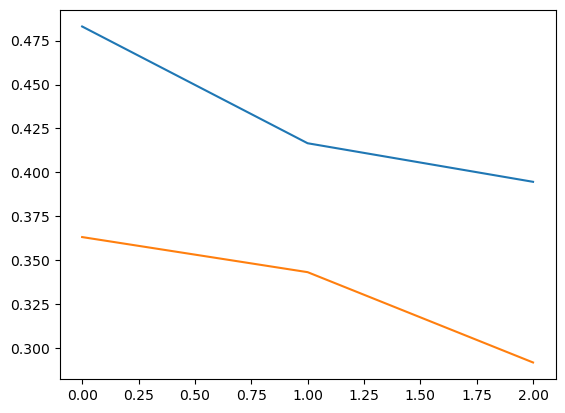

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

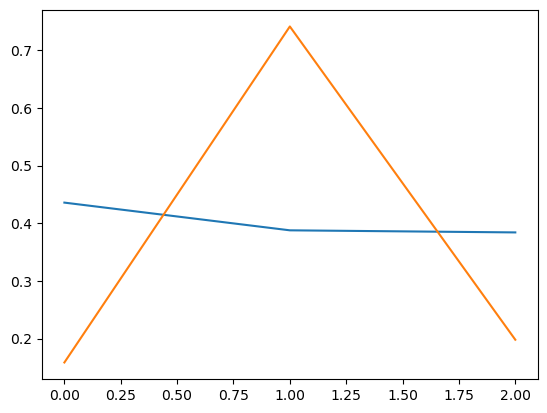

In [30]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_acc'])

In [31]:
def show_image(name, train = True):
    image = plt.imread(f'{dataset_x_path if train else dataset_y_path}{name}')
    plt.imshow(image)

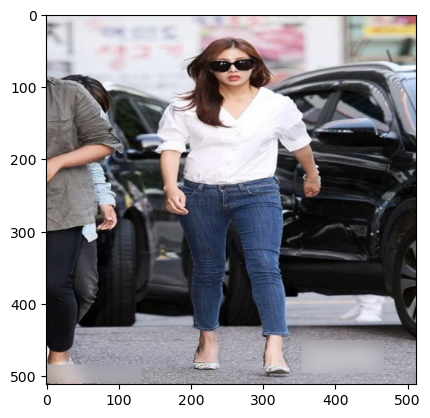

In [32]:
show_image(test_image_x[5])

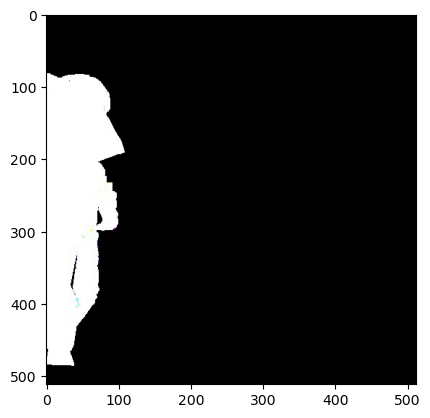

In [33]:
show_image(test_image_y[5],False)

In [37]:
image = cv2.imread(f'{modified_image_directory}{test_image_x[5]}')
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image = image.reshape(512, 512, 1)
prediction = model.predict(np.array([image]))

1/1 [==============================] - 0s 486ms/step


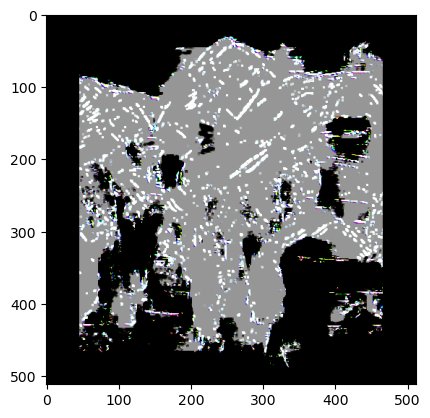

In [38]:
plt.imshow(prediction[0])

In [61]:
image.reshape(-1, 1).shape

(786432, 1)

In [62]:
prediction.reshape(-1, 1).shape

(786432, 1)

In [63]:
def new_mask(real_img, m_img):
    real_img = real_img.reshape(1, -1)[0]
    m_img = m_img.reshape(1, -1)[0]
    new_np = np.where(m_img > 0.8, real_img, 0).reshape(512, 512, 3)
    return new_np

In [64]:
new_image = new_mask(image, prediction)

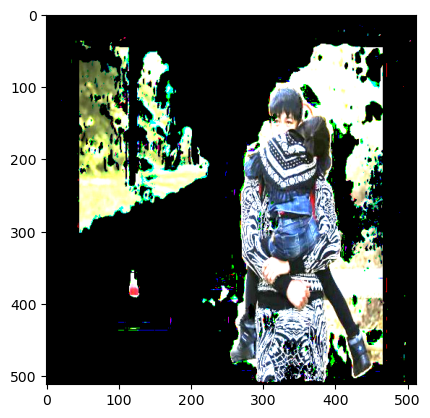

In [65]:
plt.imshow(new_image)

In [66]:
def blur_image(original_image, mask):
    blured_image = cv2.blur(original_image, (10, 10)).reshape(1, -1)[0]
    original_image = original_image.reshape(1, -1)[0]
    mask = mask.reshape(1, -1)[0]
    new_image = np.where(mask > 0.8, original_image, blured_image).reshape(512, 512, 3)
    return new_image

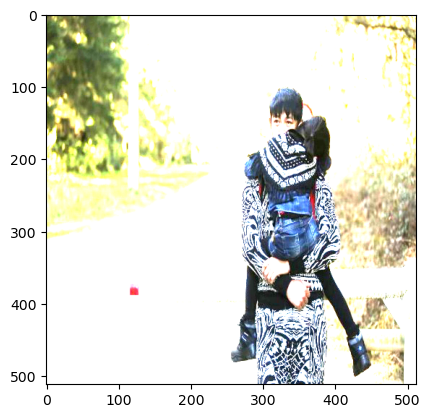

In [67]:
plt.imshow(image)

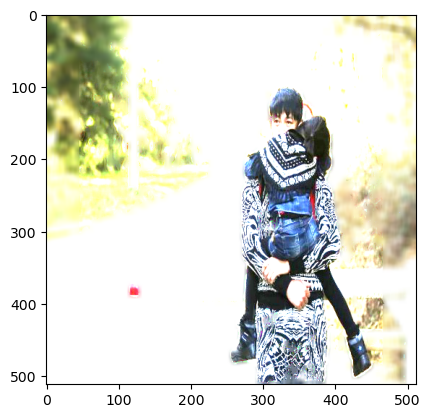

In [68]:
blurred_image = blur_image(image, prediction)
plt.imshow(blurred_image)

In [69]:
model.save("/volume/Programming/Jupyter/Image Segmentation/model.h5")

In [70]:
image_segmentor = load_model('model.h5', compile=False)
image_segmentor.compile()

In [73]:
vid = cv2.VideoCapture(0)

while True:
    ret, frame = vid.read()
    frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
    modified_frame = cv2.convertScaleAbs(frame, 0.1, 4)
    segmentation = image_segmentor.predict(np.array([modified_frame]))
    new_image = new_mask(frame, segmentation)
    cv2.imshow('Image Segmentation', new_image)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
vid.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step
